In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Importing Necessary Modules
import os
import re
import cv2
import time
import random
import warnings
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path
from PIL import Image
from tqdm import tqdm

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K



%matplotlib inline
warnings.filterwarnings('ignore')

### Data Preprocessing

In [8]:
os.chdir("/content/drive/MyDrive/")

In [9]:
!pwd

/content/drive/MyDrive


In [10]:
#variables to easily perform iterations 
image_size_to_train = (128, 128)

#we will store all the results in each iteration in a 
report = {}
training_times = {}
best_params = {}
training_hyper_times = {}

vis_path='visualizations/{}'.format(image_size_to_train[0])
Path(vis_path).mkdir(parents=True, exist_ok=True)

# Machine Learning

In [11]:
dataset_path="archive"
image_paths = []
labels = []
for sub_fol in os.listdir(dataset_path):
  for img in os.listdir(f"{dataset_path}/{sub_fol}"):
    image_paths.append(f"{dataset_path}/{sub_fol}/{img}")
    labels.append(sub_fol)

unique_labels = os.listdir(dataset_path)
print("Number of images found:", len(image_paths))
print("Number of unique labels:",len(unique_labels))
print("Unique labels:", unique_labels)

Number of images found: 4010
Number of unique labels: 8
Unique labels: ['Powdery Mildew', 'Cutting Weevil', 'Die Back', 'Sooty Mould', 'Gall Midge', 'Bacterial Canker', 'Anthracnose', 'Healthy']


In [12]:
#convert labels to numbers using LabelEncoder
le = LabelEncoder()
le.fit(labels)
labels = le.transform(labels)

#get labels names
labels_to_names = dict(zip(le.transform(le.classes_), le.classes_))
print("Labels to names:",labels_to_names)

Labels to names: {0: 'Anthracnose', 1: 'Bacterial Canker', 2: 'Cutting Weevil', 3: 'Die Back', 4: 'Gall Midge', 5: 'Healthy', 6: 'Powdery Mildew', 7: 'Sooty Mould'}


In [13]:
#now split the data into train and test sets in the ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.3, train_size = 0.7, random_state=42)

In [14]:
str(X_train[0])

'archive/Powdery Mildew/IMG_20211107_120354 (Custom).jpg'

In [16]:
#now we will create a function to load the images and resize them to 224x224
def process_images(paths, labels, resize = (128, 128), flatten=True, verbose=True):
    X = []
    y = []

    for i, path in enumerate(paths):
        
        if verbose:
            print("Processing image number:", i)
        
        try:
            img = cv2.imread(path)
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, resize)
            X.append(img)
            y.append(labels[i])
        
        except:
            print("Error in image: ", path)
    
    X = np.array(X)
    
    if flatten:
        X = X.reshape(X.shape[0],-1)
    
    return X,y

#now we will load the train and test images
print("Loading Training Images into memory")
X_train, y_train = process_images(X_train, y_train, resize = image_size_to_train, flatten=True, verbose=True)

print("Loading Test Images into memory")
X_test,y_test=process_images(X_test, y_test, resize = image_size_to_train,flatten=True, verbose=True)

Loading Training Images into memory
Processing image number: 0
Processing image number: 1
Processing image number: 2
Processing image number: 3
Processing image number: 4
Processing image number: 5
Processing image number: 6
Processing image number: 7
Processing image number: 8
Processing image number: 9
Processing image number: 10
Processing image number: 11
Processing image number: 12
Processing image number: 13
Processing image number: 14
Processing image number: 15
Processing image number: 16
Processing image number: 17
Processing image number: 18
Processing image number: 19
Processing image number: 20
Processing image number: 21
Processing image number: 22
Processing image number: 23
Processing image number: 24
Processing image number: 25
Processing image number: 26
Processing image number: 27
Processing image number: 28
Processing image number: 29
Processing image number: 30
Processing image number: 31
Processing image number: 32
Processing image number: 33
Processing image numbe

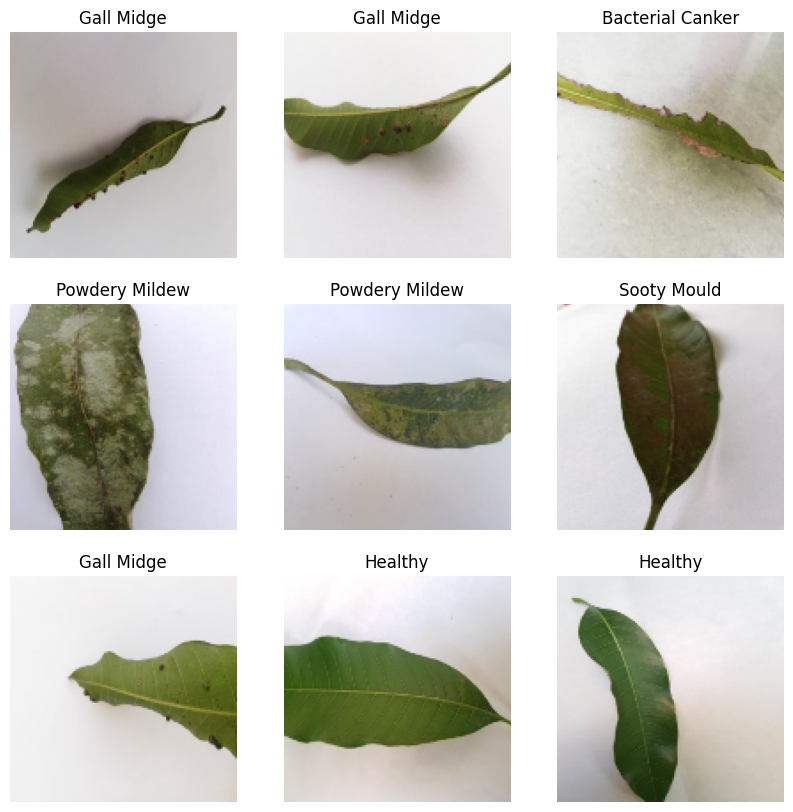

In [17]:
#visualize the resized images again
fig = plt.figure(figsize = (10,10))

for i in range(9):
    ax = fig.add_subplot(3,3,i+1)
    random_index = random.randint(0,len(X_train))
    img = X_train[random_index].reshape(image_size_to_train[0],image_size_to_train[1],3)
    ax.imshow(img)
    ax.set_title(labels_to_names[y_train[random_index]])
    ax.axis('off')

In [18]:
models = {
    "Logistic Regression": LogisticRegression(), 
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(), 
    "Decision Tree": DecisionTreeClassifier()}#, 
    #"Random Forest": RandomForestClassifier(), 
    #"SVM" : SVC()
#}

param_grid = {
    "KNN": dict(n_neighbors = [5, 7, 11, 13], weights = ['uniform', 'distance']), 
    #"SVM": dict(gamma = [1, 10, 100], kernel = ["rbf", "poly"], C = [10, 50, 100]),
    #"Random Forest": dict(n_estimators = np.arange(100, 300, 50), criterion = ["gini", "entropy", "log_loss"]),
    "Logistic Regression": None,
    "Decision Tree": dict(max_depth = np.arange(100, 350, 50), criterion = ["gini", "entropy", "log_loss"]),
    "Naive Bayes": None
    }

In [19]:
def hyper_parameter_tuning():

  for idx in range(len(list(models))):

    model = list(models.values())[idx]
    params = param_grid[list(models.keys())[idx]]

    print(f'Working on {list(models.keys())[idx]} algorithm...')

    if params is not None:
      start_time = time.time()
      gs = GridSearchCV(model, params, cv = 3, n_jobs = -1)
      gs.fit(X_train, y_train)
      training_hyper_times[list(models.keys())[idx]] = time.time() - start_time

      best_params[list(models.keys())[idx]] = gs.best_params_

      start_time = time.time()
      model.set_params(**gs.best_params_)
      model.fit(X_train, y_train)
      training_times[list(models.keys())[idx]] = time.time() - start_time

    else:
      start_time = time.time()
      model.fit(X_train, y_train)
      training_hyper_times[list(models.keys())[idx]] = None
      training_times[list(models.keys())[idx]] = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_model_score = accuracy_score(y_train, y_train_pred) * 100
    test_model_score = accuracy_score(y_test, y_test_pred) * 100

    print(f"Accuracy for {list(models.keys())[idx]} is: {test_model_score}")

    report[list(models.keys())[idx]] = test_model_score

  return report

In [20]:
report = hyper_parameter_tuning()

Working on Logistic Regression algorithm...
Accuracy for Logistic Regression is: 74.1479634247714
Working on Naive Bayes algorithm...
Accuracy for Naive Bayes is: 52.452202826267666
Working on KNN algorithm...
Accuracy for KNN is: 68.5785536159601
Working on Decision Tree algorithm...
Accuracy for Decision Tree is: 66.25103906899417


In [ ]:
# Best Parameters are
# KNN
# n_neighbors = 13, weights = "distance"
# SVM
# C = 10, gamma = 1, kernel = "poly"
# Random Forest
# criterion = entropy, n_estimators = 250
# Decision Tree
# criterion = gini, max_depth = 100

In [21]:
algos_param = list(best_params.keys())
params_params = list(best_params.values())
pd.DataFrame({"Algorithms": algos_param, "Parameters": params_params}).to_csv("Best_Params_128.csv")

In [22]:
algos_hyper_time = list(training_hyper_times.keys())
time_hyper_time = [round(k, 2) if k is not None else 0 for k in list(training_hyper_times.values())]
pd.DataFrame({"Algorithms": algos_hyper_time, "Time in seconds": time_hyper_time}).to_csv("Hyper_Time_128.csv")

# Deep Learning

In [23]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNEL = 3
EPOCHS = 100

In [24]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/archive",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE,
    )

Found 4010 files belonging to 8 classes.


In [25]:
class_names = dataset.class_names
class_names

['Anthracnose',
 'Bacterial Canker',
 'Cutting Weevil',
 'Die Back',
 'Gall Midge',
 'Healthy',
 'Powdery Mildew',
 'Sooty Mould']

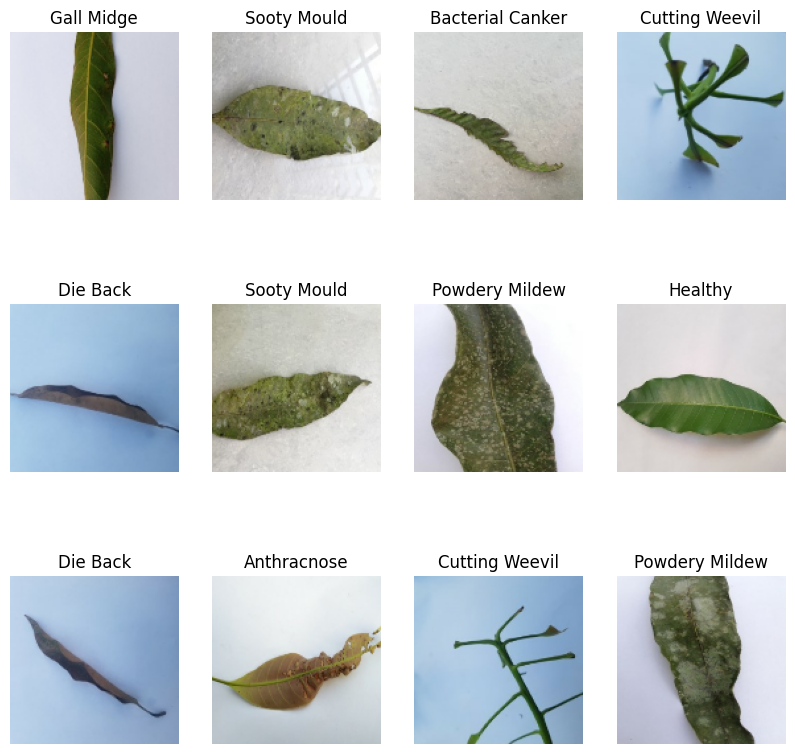

In [26]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.axis("off")
    plt.title(class_names[label_batch[i]])

In [27]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  ds_size = len(ds) # taking number of batches into account
  train_size = int(ds_size * train_split) # evaluating number of batches to be in training dataset
  val_size = int(ds_size * val_split) # evaluating number of batches to be in validation dataset
  
  train_ds = ds.take(train_size) # creating training dataset partition
  #ds.skip(train_size) # skipping batches which are in training dataset
  
  val_ds = ds.skip(train_size).take(val_size) # creating validation dataset partition
  test_ds = ds.skip(train_size).skip(val_size) # creating testing dataset partition
  
  return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [28]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [29]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    ])

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    ])

In [30]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNEL)
number_of_classes = len(class_names)

In [31]:
metric="val_categorical_accuracy"

def create_callbacks(metric = metric, filename = "base_model_256.h5", patience=5):
     Path("models").mkdir(parents=True, exist_ok =True)
     cpk_path ="models/"+filename
     checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath = cpk_path,
        monitor= metric,
        mode='auto',
        save_best_only=True,
        verbose=1,
    )
     earlystop = tf.keras.callbacks.EarlyStopping(
        monitor = metric,
        mode='auto',
        patience=patience,
        verbose=1
    )
     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor = metric,
        mode='auto',
        patience=patience//2,
        verbose=1,
        factor=0.5
    )
     callbacks = [checkpoint, earlystop, reduce_lr]
     return callbacks

In [32]:
tf.keras.backend.clear_session()
with tf.device('/device:GPU:1'):
  vanilla_cnn = tf.keras.Sequential([
          # resize_rescale,
          data_augmentation,
          tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape = input_shape),
          tf.keras.layers.MaxPool2D(),
          tf.keras.layers.Conv2D(64, 3, activation='relu'), 
          tf.keras.layers.MaxPool2D(), 
          tf.keras.layers.Conv2D(128, 3, activation='relu'), 
          tf.keras.layers.MaxPool2D(), 
          tf.keras.layers.Conv2D(256, 3, activation='relu'), 
          tf.keras.layers.MaxPool2D(), 
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(512, activation='relu'), 
          tf.keras.layers.Dense(number_of_classes, activation='sigmoid'),                 
      ])
  vanilla_cnn.build(input_shape)
  vanilla_cnn.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                                  loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                                  metrics = 'categorical_accuracy')
  callbacks = create_callbacks(metric = metric, filename = "vanilla_cnn_256.h5", patience = 10)
  start_time = time.time()
  base_history = vanilla_cnn.fit(train_ds,
                                  epochs = EPOCHS, 
                                  validation_data = val_ds, 
                                  callbacks = callbacks, 
                                  batch_size = BATCH_SIZE, 
                                  verbose = 1
                                  )

  training_times['Vanilla_CNN'] = time.time() - start_time

report["Vanilla_CNN"] = max(base_history.history['categorical_accuracy'])
vanilla_cnn.summary()

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 6.0725 - categorical_accuracy: 0.1253
Epoch 1: val_categorical_accuracy improved from -inf to 0.06510, saving model to models/vanilla_cnn_256.h5
100/100 [==============================] - 28s 95ms/step - loss: 6.0725 - categorical_accuracy: 0.1253 - val_loss: 0.9580 - val_categorical_accuracy: 0.0651 - lr: 1.0000e-04
Epoch 2/100
 98/100 [============================>.] - ETA: 0s - loss: 0.7355 - categorical_accuracy: 0.1186
Epoch 2: val_categorical_accuracy improved from 0.06510 to 0.16406, saving model to models/vanilla_cnn_256.h5
100/100 [==============================] - 2s 23ms/step - loss: 0.7327 - categorical_accuracy: 0.1191 - val_loss: 0.6271 - val_categorical_accuracy: 0.1641 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.5456 - categorical_accuracy: 0.1191
Epoch 3: val_categorical_accuracy did not improve from 0.16406
100/100 [==============================] - 2s 

In [33]:
tf.keras.backend.clear_session()
with tf.device('/device:GPU:0'):
  efficient_model = tf.keras.Sequential([
      # resize_rescale,
      # data_augmentation,
      tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False, weights='imagenet', input_shape = input_shape[1:]),
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(512, activation = tf.keras.layers.LeakyReLU(alpha=0.2)),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(128, activation = tf.keras.layers.LeakyReLU(alpha=0.2)),
      tf.keras.layers.Dense(number_of_classes, activation="sigmoid", dtype='float32')

  ])
  efficient_model.build(input_shape)
  efficient_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
                          loss = tf.keras.losses.SparseCategoricalCrossentropy(), 
                          metrics = 'categorical_accuracy'
                          )
  callbacks = create_callbacks(filename="efficient_net_v2_model_256.h5")
  start_time = time.time()
  effn_history = efficient_model.fit(train_ds, 
                                     epochs = EPOCHS, 
                                     validation_data = val_ds, 
                                     callbacks = callbacks, 
                                     batch_size = BATCH_SIZE
                                     )
  training_times['EfficientNetV2'] = time.time() - start_time
report["Efficient_Net_V2"] = max(effn_history.history['categorical_accuracy'])

24274472/24274472 [==============================] - 0s 0us/step
Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.2798 - categorical_accuracy: 0.1231
Epoch 1: val_categorical_accuracy improved from -inf to 0.09896, saving model to models/efficient_net_v2_model_256.h5
100/100 [==============================] - 66s 132ms/step - loss: 0.2798 - categorical_accuracy: 0.1231 - val_loss: 0.0571 - val_categorical_accuracy: 0.0990 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.1175 - categorical_accuracy: 0.1244
Epoch 2: val_categorical_accuracy improved from 0.09896 to 0.10156, saving model to models/efficient_net_v2_model_256.h5
100/100 [==============================] - 10s 98ms/step - loss: 0.1175 - categorical_accuracy: 0.1244 - val_loss: 0.0276 - val_categorical_accuracy: 0.1016 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.0363 - categorical_accuracy: 0.1250
Epoch 3: val_categorical_acc

In [34]:
algos_time = list(training_times.keys())
time_time = [round(k, 2) for k in list(training_times.values())]
pd.DataFrame({"Algorithms": algos_time, "Time in seconds": time_time}).to_csv("Training_Time_128.csv")

In [35]:
algos = list(report.keys())
accuracies = list(report.values())
dict_report = pd.DataFrame({"Algorithms": algos, "Accuracies": accuracies})
dict_report.to_csv("Report_ML_128.csv")

<Axes: xlabel='Algorithms', ylabel='Accuracies'>

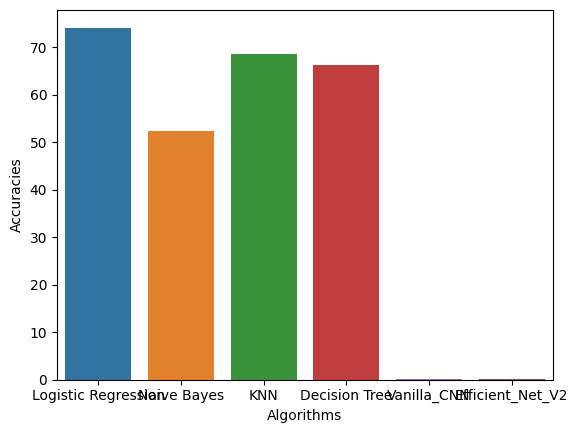

In [36]:
reports = pd.read_csv("Report_ML_128.csv")
sns.barplot(x = "Algorithms", y = "Accuracies", data = reports)

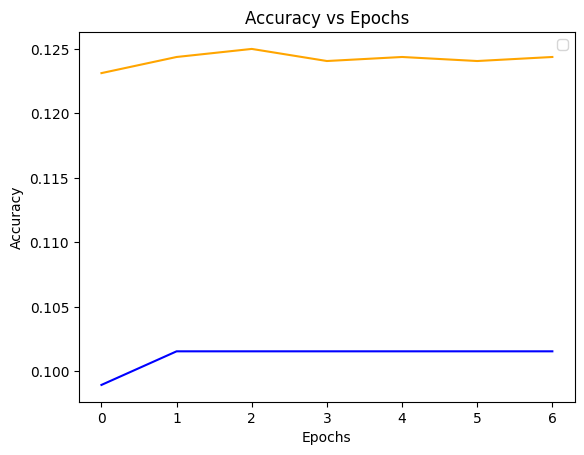

In [37]:
epochs = list(range(len(effn_history.history['categorical_accuracy'])))
plt.plot(epochs, effn_history.history['categorical_accuracy'], color = 'orange')
plt.plot(epochs, effn_history.history['val_categorical_accuracy'], color = 'blue')
plt.legend(loc = 'upper right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs")
plt.show()

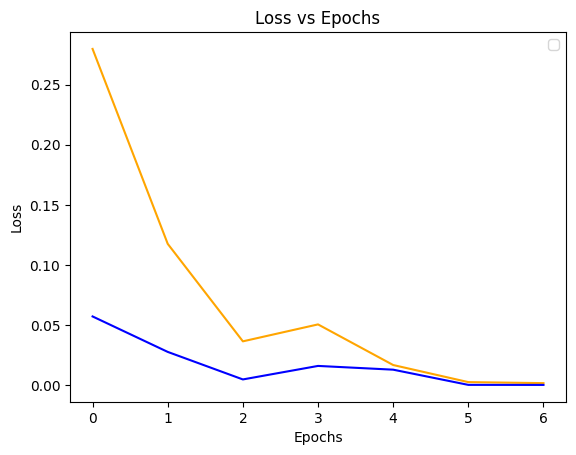

In [38]:
epochs = list(range(len(effn_history.history['categorical_accuracy'])))
plt.plot(epochs, effn_history.history['loss'], color = 'orange')
plt.plot(epochs, effn_history.history['val_loss'], color = 'blue')
plt.legend(loc = 'upper right')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()